In [1]:
from astropy.coordinates import SkyCoord
from panstarrs3 import panstarrs as p3

In [3]:
tcoord = SkyCoord.from_name('Kepler 13')
ps = p3.Panstarrs(ra=tcoord.ra.deg, dec=tcoord.dec.deg,
                  color=True)

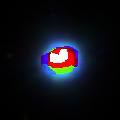

In [4]:
ps.color = True
cimg = ps.get_color_img()
cimg

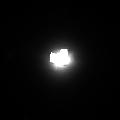

In [5]:
gimg = ps.get_gray_img(filter='g')
gimg 

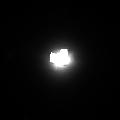

In [6]:
gimg = ps.get_gray_img(filter='z')
gimg 

In [7]:
ps.color = False
img, hdr = ps.get_fits(verbose=True)

Filename: /home/jp/.astropy/cache/download/py3/fbcf4addba658fc436a937c50faf3948
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     246   (120, 120)   float32   
None


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


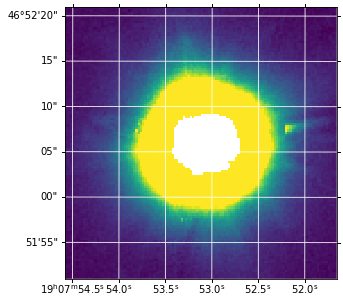

In [9]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval
from astropy.wcs import WCS
import matplotlib.pyplot as pl
from astropy import units as u

# tcoord = SkyCoord.from_name('Kepler 13')
ps = p3.Panstarrs(ra=tcoord.ra.deg, dec=tcoord.dec.deg,
               filters="g", format="fits", color=False)
interval = ZScaleInterval(contrast=0.5)
img, hdr = ps.get_fits(verbose=False)
zmin, zmax = interval.get_limits(img)

fig = pl.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection=WCS(hdr))
ax.imshow(img, vmin=zmin, vmax=zmax, cmap='viridis', origin='lower')
ax.grid(color='white', ls='solid')

(<matplotlib.axes._subplots.WCSAxesSubplot at 0x7f69c21fac10>,
 <astropy.io.fits.hdu.image.PrimaryHDU at 0x7f69c21fa610>)

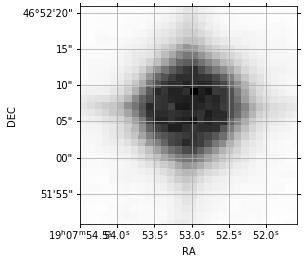

In [10]:
from astroplan.plots import plot_finder_image

plot_finder_image(tcoord, survey='DSS2 Red', fov_radius=30*u.arcsec)